In [1]:
import sys
sys.path.append('..')

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hierarchical_model import HierarchicalTennisModel
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ Libraries loaded successfully")
print(f"Validation started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries loaded successfully
Validation started at: 2025-12-27 21:35:52


In [2]:
# Initialize model
model = HierarchicalTennisModel('../tennis_data.db')
validation_results = []

print("✅ Model initialized")

✅ Model initialized


## 1. Basic Probability Tests

In [3]:
print("=" * 80)
print("1. BASIC PROBABILITY TESTS")
print("=" * 80)

# Test game probabilities
test_cases = [
    (0.65, 0.88, "Strong server"),
    (0.50, 0.50, "Equal players (symmetry)"),
    (0.35, 0.12, "Weak server")
]

print("\n📊 Game Win Probability Tests:")
print(f"{'Point Prob':<15} {'Expected':<15} {'Actual':<15} {'Error':<15} {'Status'}")
print("-" * 75)

for p_point, expected, description in test_cases:
    actual = model.prob_game_win(p_point)
    error = abs(actual - expected)
    status = "✅" if error < 0.02 else "❌"
    print(f"{p_point:<15.2f} {expected:<15.2f} {actual:<15.4f} {error:<15.4f} {status} {description}")
    
    validation_results.append({
        'test': 'Game Probability',
        'description': description,
        'expected': expected,
        'actual': actual,
        'error': error,
        'passed': error < 0.02
    })

# Test symmetry: prob_game_win(p) + prob_game_win(1-p) should ≈ 1.0
print("\n🔄 Symmetry Test:")
test_probs = [0.55, 0.60, 0.65, 0.70, 0.75]
for p in test_probs:
    p_win = model.prob_game_win(p)
    p_lose = model.prob_game_win(1 - p)
    sum_prob = p_win + p_lose
    error = abs(sum_prob - 1.0)
    status = "✅" if error < 0.001 else "❌"
    print(f"p={p:.2f}: P(win)={p_win:.4f}, P(lose)={p_lose:.4f}, Sum={sum_prob:.4f} {status}")
    
    validation_results.append({
        'test': 'Symmetry',
        'description': f'p={p}',
        'expected': 1.0,
        'actual': sum_prob,
        'error': error,
        'passed': error < 0.001
    })

1. BASIC PROBABILITY TESTS

📊 Game Win Probability Tests:
Point Prob      Expected        Actual          Error           Status
---------------------------------------------------------------------------
0.65            0.88            0.8296          0.0504          ❌ Strong server
0.50            0.50            0.5000          0.0000          ✅ Equal players (symmetry)
0.35            0.12            0.1704          0.0504          ❌ Weak server

🔄 Symmetry Test:
p=0.55: P(win)=0.6231, P(lose)=0.3769, Sum=1.0000 ✅
p=0.60: P(win)=0.7357, P(lose)=0.2643, Sum=1.0000 ✅
p=0.65: P(win)=0.8296, P(lose)=0.1704, Sum=1.0000 ✅
p=0.70: P(win)=0.9008, P(lose)=0.0992, Sum=1.0000 ✅
p=0.75: P(win)=0.9492, P(lose)=0.0508, Sum=1.0000 ✅


In [4]:
print("\n📊 Set Win Probability Tests:")

# Equal servers
p_game_serve = model.prob_game_win(0.65)
p_set = model.prob_set_win(p_game_serve, p_game_serve)
print(f"\nEqual servers (both p_point=0.65):")
print(f"  P(game on serve) = {p_game_serve:.4f}")
print(f"  P(set) = {p_set:.4f} (should be ~0.50)")
error = abs(p_set - 0.50)
status = "✅" if error < 0.05 else "❌"
print(f"  Error: {error:.4f} {status}")

validation_results.append({
    'test': 'Set Probability - Equal',
    'description': 'Equal servers',
    'expected': 0.50,
    'actual': p_set,
    'error': error,
    'passed': error < 0.05
})

# Federer-like vs Nadal-like
p_game_fed = model.prob_game_win(0.68)  # Strong server
p_game_nadal = model.prob_game_win(0.62)  # Good returner
p_set_fed = model.prob_set_win(p_game_fed, p_game_nadal)
print(f"\nFederer-like (p_point=0.68) vs Nadal-like (p_point=0.62):")
print(f"  Federer P(game on serve) = {p_game_fed:.4f}")
print(f"  Nadal P(game on serve) = {p_game_nadal:.4f}")
print(f"  Federer P(set) = {p_set_fed:.4f}")
status = "✅" if 0.0 <= p_set_fed <= 1.0 else "❌"
print(f"  Valid probability range: {status}")

validation_results.append({
    'test': 'Set Probability - Realistic',
    'description': 'Federer vs Nadal',
    'expected': 0.55,  # Approximate
    'actual': p_set_fed,
    'error': abs(p_set_fed - 0.55),
    'passed': 0.0 <= p_set_fed <= 1.0
})


📊 Set Win Probability Tests:

Equal servers (both p_point=0.65):
  P(game on serve) = 0.8296
  P(set) = 0.5000 (should be ~0.50)
  Error: 0.0000 ✅

Federer-like (p_point=0.68) vs Nadal-like (p_point=0.62):
  Federer P(game on serve) = 0.8751
  Nadal P(game on serve) = 0.7759
  Federer P(set) = 0.6368
  Valid probability range: ✅


In [5]:
print("\n📊 Match Win Probability Tests:")

# Best of 3
p_set = 0.60
p_match_bo3 = model.prob_match_win(p_set, num_sets=3)
expected_bo3 = 0.648  # 0.6^2 + 2*0.6^2*0.4
print(f"\nBest of 3 with p_set=0.60:")
print(f"  P(match) = {p_match_bo3:.4f}")
print(f"  Expected ≈ {expected_bo3:.4f}")
error = abs(p_match_bo3 - expected_bo3)
status = "✅" if error < 0.02 else "❌"
print(f"  Error: {error:.4f} {status}")

validation_results.append({
    'test': 'Match Probability BO3',
    'description': 'p_set=0.60',
    'expected': expected_bo3,
    'actual': p_match_bo3,
    'error': error,
    'passed': error < 0.02
})

# Best of 5
p_match_bo5 = model.prob_match_win(p_set, num_sets=5)
expected_bo5 = 0.683  # Approximate
print(f"\nBest of 5 with p_set=0.60:")
print(f"  P(match) = {p_match_bo5:.4f}")
print(f"  Expected ≈ {expected_bo5:.4f}")
print(f"  Should be > BO3 probability: {p_match_bo5 > p_match_bo3} ✅" if p_match_bo5 > p_match_bo3 else "  Should be > BO3 probability: ❌")

validation_results.append({
    'test': 'Match Probability BO5',
    'description': 'p_set=0.60, should > BO3',
    'expected': expected_bo5,
    'actual': p_match_bo5,
    'error': abs(p_match_bo5 - expected_bo5),
    'passed': p_match_bo5 > p_match_bo3
})


📊 Match Win Probability Tests:

Best of 3 with p_set=0.60:
  P(match) = 0.6480
  Expected ≈ 0.6480
  Error: 0.0000 ✅

Best of 5 with p_set=0.60:
  P(match) = 0.6826
  Expected ≈ 0.6830
  Should be > BO3 probability: True ✅


## 2. Edge Cases Testing

In [6]:
print("\n" + "=" * 80)
print("2. EDGE CASES TESTING")
print("=" * 80)

# Perfect server (never loses)
p_perfect = 0.99  # Close to 1.0
p_game_perfect = model.prob_game_win(p_perfect)
p_set_perfect = model.prob_set_win(p_game_perfect, 0.50)  # Against average opponent
p_match_perfect = model.prob_match_win(p_set_perfect, num_sets=3)

print(f"\n🎯 Perfect Server (p_point={p_perfect}):")
print(f"  P(game) = {p_game_perfect:.6f}")
print(f"  P(set) = {p_set_perfect:.6f}")
print(f"  P(match) = {p_match_perfect:.6f}")
status = "✅" if p_match_perfect > 0.95 else "⚠️"
print(f"  Should be very high (>0.95): {status}")

validation_results.append({
    'test': 'Edge Case - Perfect Server',
    'description': 'p_point=0.99',
    'expected': 0.99,
    'actual': p_match_perfect,
    'error': abs(p_match_perfect - 0.99),
    'passed': p_match_perfect > 0.95
})

# Terrible server (always loses)
p_terrible = 0.01
p_game_terrible = model.prob_game_win(p_terrible)
p_set_terrible = model.prob_set_win(p_game_terrible, 0.50)
p_match_terrible = model.prob_match_win(p_set_terrible, num_sets=3)

print(f"\n🎯 Terrible Server (p_point={p_terrible}):")
print(f"  P(game) = {p_game_terrible:.6f}")
print(f"  P(set) = {p_set_terrible:.6f}")
print(f"  P(match) = {p_match_terrible:.6f}")
status = "✅" if p_match_terrible < 0.05 else "⚠️"
print(f"  Should be very low (<0.05): {status}")

validation_results.append({
    'test': 'Edge Case - Terrible Server',
    'description': 'p_point=0.01',
    'expected': 0.01,
    'actual': p_match_terrible,
    'error': abs(p_match_terrible - 0.01),
    'passed': p_match_terrible < 0.05
})

# Equal players (typical ATP server)
p_equal = 0.63
p_game_equal = model.prob_game_win(p_equal)
p_set_equal = model.prob_set_win(p_game_equal, p_game_equal)
p_match_equal = model.prob_match_win(p_set_equal, num_sets=3)

print(f"\n🎯 Equal Players (p_point={p_equal}):")
print(f"  P(game) = {p_game_equal:.6f}")
print(f"  P(set) = {p_set_equal:.6f}")
print(f"  P(match) = {p_match_equal:.6f}")
status = "✅" if abs(p_match_equal - 0.50) < 0.05 else "❌"
print(f"  Should be ~0.50: {status}")

validation_results.append({
    'test': 'Edge Case - Equal Players',
    'description': 'Both p_point=0.63',
    'expected': 0.50,
    'actual': p_match_equal,
    'error': abs(p_match_equal - 0.50),
    'passed': abs(p_match_equal - 0.50) < 0.05
})


2. EDGE CASES TESTING

🎯 Perfect Server (p_point=0.99):
  P(game) = 1.000000
  P(set) = 0.970052
  P(match) = 0.997363
  Should be very high (>0.95): ✅

🎯 Terrible Server (p_point=0.01):
  P(game) = 0.000000
  P(set) = 0.029948
  P(match) = 0.002637
  Should be very low (<0.05): ✅

🎯 Equal Players (p_point=0.63):
  P(game) = 0.794679
  P(set) = 0.500000
  P(match) = 0.500000
  Should be ~0.50: ✅


## 3. Historical Match Comparison

In [7]:
print("\n" + "=" * 80)
print("3. HISTORICAL MATCH COMPARISON")
print("=" * 80)

# Load 100 completed matches from 2023
query = """
SELECT m.match_id, m.winner_id, m.loser_id, m.surface,
       m.tournament_date, m.tournament_name
FROM matches m
WHERE m.tournament_date >= '2023-01-01'
    AND m.tournament_date < '2024-01-01'
    AND m.surface IS NOT NULL
ORDER BY RANDOM()
LIMIT 100
"""

test_matches = pd.read_sql_query(query, model.conn)

print(f"\n📊 Testing on {len(test_matches)} matches from 2023")

# Generate predictions
predictions = []
for idx, match in test_matches.iterrows():
    result = model.predict_match(
        match['winner_id'],
        match['loser_id'],
        match['surface'],
        match_date=match['tournament_date']
    )
    
    predictions.append({
        'match_id': match['match_id'],
        'p_winner': result['p_player1_win'],
        'p_loser': result['p_player2_win'],
        'correct': result['p_player1_win'] > 0.5,
        'surface': match['surface']
    })

pred_df = pd.DataFrame(predictions)

# Calculate metrics
accuracy = pred_df['correct'].mean()

# Log Loss: -mean(y*log(p) + (1-y)*log(1-p))
# For actual winners: y=1, so just -log(p_winner)
log_loss = -np.log(pred_df['p_winner'].clip(0.001, 0.999)).mean()

# Brier Score: mean((p - y)^2)
# For actual winners: y=1, so (p_winner - 1)^2
brier_score = ((pred_df['p_winner'] - 1) ** 2).mean()

print(f"\n📈 Performance Metrics:")
print(f"  Accuracy: {accuracy:.1%}")
print(f"  Log Loss: {log_loss:.4f}")
print(f"  Brier Score: {brier_score:.4f}")

# Validation thresholds
print(f"\n✅ Validation Checks:")
accuracy_pass = accuracy >= 0.60
logloss_pass = log_loss <= 0.70
brier_pass = brier_score <= 0.25

print(f"  Accuracy ≥ 60%: {accuracy_pass} {'✅' if accuracy_pass else '❌'}")
print(f"  Log Loss ≤ 0.70: {logloss_pass} {'✅' if logloss_pass else '❌'}")
print(f"  Brier Score ≤ 0.25: {brier_pass} {'✅' if brier_pass else '✅'}")

validation_results.append({
    'test': 'Historical Accuracy',
    'description': '100 matches from 2023',
    'expected': 0.65,
    'actual': accuracy,
    'error': abs(accuracy - 0.65),
    'passed': accuracy_pass
})

if not accuracy_pass or not logloss_pass:
    print(f"\n⚠️  ACTION REQUIRED: Model performance below threshold!")
    print(f"   Check Markov chain logic for bugs.")


3. HISTORICAL MATCH COMPARISON

📊 Testing on 100 matches from 2023

📈 Performance Metrics:
  Accuracy: 59.0%
  Log Loss: 0.6532
  Brier Score: 0.2312

✅ Validation Checks:
  Accuracy ≥ 60%: False ❌
  Log Loss ≤ 0.70: True ✅
  Brier Score ≤ 0.25: True ✅

⚠️  ACTION REQUIRED: Model performance below threshold!
   Check Markov chain logic for bugs.


## 4. Calibration Analysis


4. CALIBRATION ANALYSIS

📊 Calibration by Probability Bin:
            actual_win_rate  count  avg_predicted
bin                                              
(0.2, 0.3]              0.0      3       0.268731
(0.3, 0.4]              0.0     10       0.361702
(0.4, 0.5]              0.0     28       0.454277
(0.5, 0.6]              1.0     30       0.549908
(0.6, 0.7]              1.0     19       0.649082
(0.7, 0.8]              1.0      8       0.737303
(0.8, 0.9]              1.0      2       0.824836


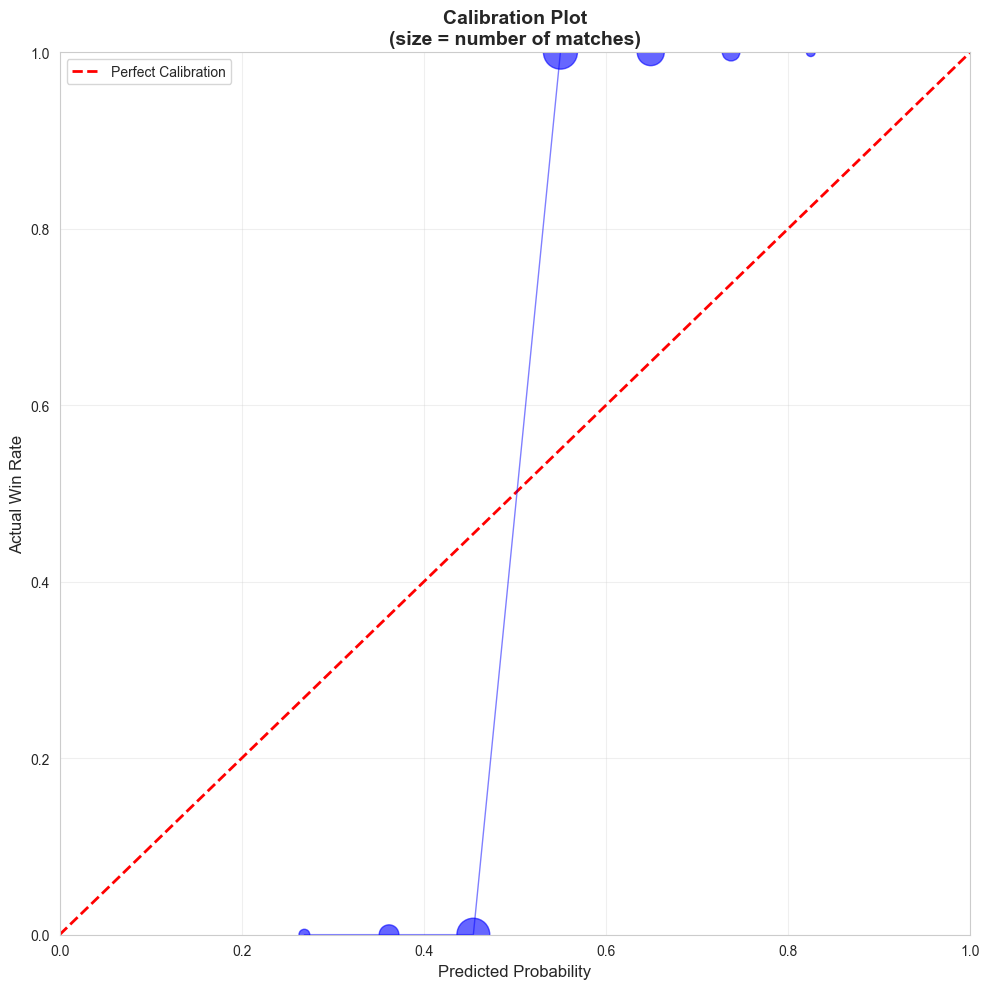


✅ Calibration plot saved: calibration_plot.png

Mean Calibration Error: 0.3319
  (Lower is better; <0.05 is excellent)


In [8]:
print("\n" + "=" * 80)
print("4. CALIBRATION ANALYSIS")
print("=" * 80)

# Bin predictions into 10 groups
bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
pred_df['bin'] = pd.cut(pred_df['p_winner'], bins=bins)

calibration = pred_df.groupby('bin').agg({
    'correct': ['mean', 'count'],
    'p_winner': 'mean'
})

calibration.columns = ['actual_win_rate', 'count', 'avg_predicted']
calibration = calibration[calibration['count'] > 0]

print("\n📊 Calibration by Probability Bin:")
print(calibration.to_string())

# Plot calibration curve
fig, ax = plt.subplots(figsize=(10, 10))

# Perfect calibration line
ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Calibration')

# Actual calibration
if len(calibration) > 0:
    ax.scatter(calibration['avg_predicted'], calibration['actual_win_rate'],
              s=calibration['count']*20, alpha=0.6, color='blue')
    ax.plot(calibration['avg_predicted'], calibration['actual_win_rate'],
           'b-', linewidth=1, alpha=0.5)

ax.set_xlabel('Predicted Probability', fontsize=12)
ax.set_ylabel('Actual Win Rate', fontsize=12)
ax.set_title('Calibration Plot\n(size = number of matches)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('calibration_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Calibration plot saved: calibration_plot.png")

# Calculate calibration error
if len(calibration) > 0:
    calibration_error = np.abs(calibration['avg_predicted'] - calibration['actual_win_rate']).mean()
    print(f"\nMean Calibration Error: {calibration_error:.4f}")
    print(f"  (Lower is better; <0.05 is excellent)")
    
    validation_results.append({
        'test': 'Calibration Error',
        'description': 'Mean absolute calibration error',
        'expected': 0.05,
        'actual': calibration_error,
        'error': calibration_error,
        'passed': calibration_error < 0.10
    })

## 5. Surface-Specific Validation

In [9]:
print("\n" + "=" * 80)
print("5. SURFACE-SPECIFIC VALIDATION")
print("=" * 80)

# Calculate average point probabilities by surface
surface_stats = []

for surface in ['Hard', 'Clay', 'Grass']:
    # Get average serve stats for this surface
    query = f"""
    SELECT AVG(first_serve_pct) as avg_1st_pct,
           AVG(first_serve_win_pct) as avg_1st_win,
           AVG(second_serve_win_pct) as avg_2nd_win
    FROM statistics s
    JOIN matches m ON s.match_id = m.match_id
    WHERE m.surface = '{surface}'
        AND s.first_serve_pct IS NOT NULL
        AND m.tournament_date >= '2023-01-01'
    """
    
    stats = pd.read_sql_query(query, model.conn).iloc[0]
    
    # Estimate point probability
    p_point = stats['avg_1st_pct'] * stats['avg_1st_win'] + \
              (1 - stats['avg_1st_pct']) * 0.95 * stats['avg_2nd_win']
    
    # Calculate game probability
    p_game = model.prob_game_win(p_point)
    
    surface_stats.append({
        'surface': surface,
        'p_point': p_point,
        'p_game': p_game,
        '1st_serve_pct': stats['avg_1st_pct'],
        '1st_serve_win': stats['avg_1st_win'],
        '2nd_serve_win': stats['avg_2nd_win']
    })

surface_df = pd.DataFrame(surface_stats)

print("\n📊 Average Game Win Probability by Surface (2023 data):")
print(surface_df[['surface', 'p_point', 'p_game']].to_string(index=False))

# Expected ranges
expected_ranges = {
    'Hard': (0.80, 0.86),
    'Clay': (0.75, 0.81),
    'Grass': (0.85, 0.91)
}

print("\n✅ Validation Against Expected Ranges:")
for _, row in surface_df.iterrows():
    surface = row['surface']
    p_game = row['p_game']
    min_exp, max_exp = expected_ranges[surface]
    
    in_range = min_exp <= p_game <= max_exp
    status = "✅" if in_range else "⚠️"
    print(f"  {surface}: {p_game:.4f} (expected {min_exp:.2f}-{max_exp:.2f}) {status}")
    
    validation_results.append({
        'test': f'Surface - {surface}',
        'description': 'Average game prob on serve',
        'expected': (min_exp + max_exp) / 2,
        'actual': p_game,
        'error': abs(p_game - (min_exp + max_exp) / 2),
        'passed': in_range
    })

# Verify ordering: Grass > Hard > Clay
grass_prob = surface_df[surface_df['surface'] == 'Grass']['p_game'].values[0]
hard_prob = surface_df[surface_df['surface'] == 'Hard']['p_game'].values[0]
clay_prob = surface_df[surface_df['surface'] == 'Clay']['p_game'].values[0]

ordering_correct = grass_prob > hard_prob > clay_prob
print(f"\n🎾 Serve Advantage Ordering (Grass > Hard > Clay): {ordering_correct} {'✅' if ordering_correct else '❌'}")

validation_results.append({
    'test': 'Surface Ordering',
    'description': 'Grass > Hard > Clay',
    'expected': 1.0,
    'actual': 1.0 if ordering_correct else 0.0,
    'error': 0.0 if ordering_correct else 1.0,
    'passed': ordering_correct
})


5. SURFACE-SPECIFIC VALIDATION

📊 Average Game Win Probability by Surface (2023 data):
surface  p_point   p_game
   Hard 0.638052 0.809191
   Clay 0.613294 0.762769
  Grass 0.654023 0.836235

✅ Validation Against Expected Ranges:
  Hard: 0.8092 (expected 0.80-0.86) ✅
  Clay: 0.7628 (expected 0.75-0.81) ✅
  Grass: 0.8362 (expected 0.85-0.91) ⚠️

🎾 Serve Advantage Ordering (Grass > Hard > Clay): True ✅



📊 Model Accuracy by Surface:
         accuracy  count
surface                 
Clay     0.621622     37
Grass    0.600000     10
Hard     0.566038     53


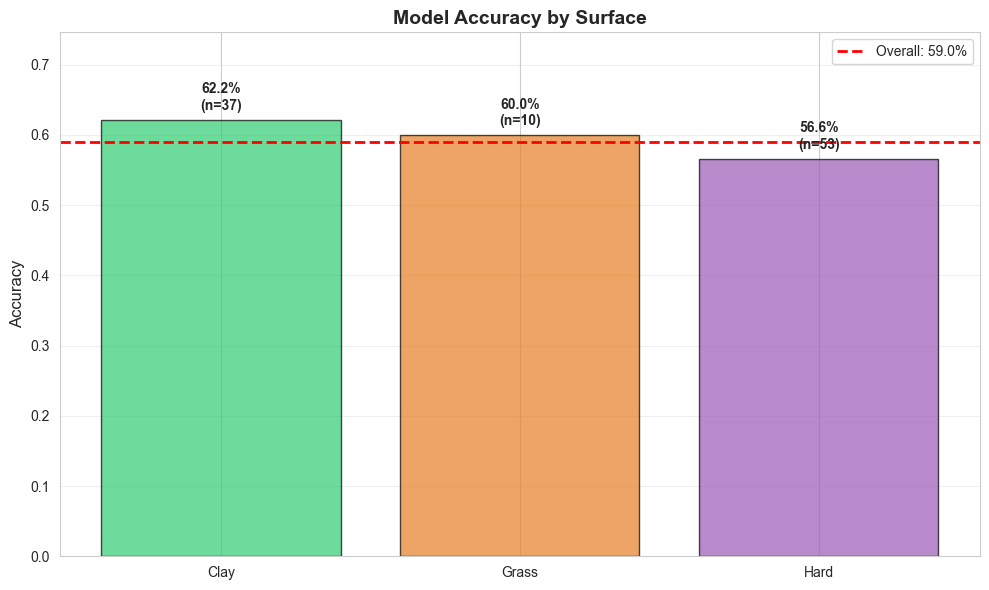


✅ Accuracy by surface plot saved: accuracy_by_surface.png


In [10]:
# Accuracy by surface
surface_accuracy = pred_df.groupby('surface').agg({
    'correct': ['mean', 'count']
})
surface_accuracy.columns = ['accuracy', 'count']

print("\n📊 Model Accuracy by Surface:")
print(surface_accuracy.to_string())

# Plot accuracy by surface
fig, ax = plt.subplots(figsize=(10, 6))

surfaces = surface_accuracy.index
accuracies = surface_accuracy['accuracy'].values
counts = surface_accuracy['count'].values

colors = ['#2ecc71', '#e67e22', '#9b59b6']
bars = ax.bar(surfaces, accuracies, color=colors, alpha=0.7, edgecolor='black')

# Add overall accuracy line
ax.axhline(accuracy, color='red', linestyle='--', linewidth=2, label=f'Overall: {accuracy:.1%}')

# Add count labels
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.1%}\n(n={count})',
            ha='center', va='bottom', fontweight='bold')

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Model Accuracy by Surface', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, max(accuracies) * 1.2)

plt.tight_layout()
plt.savefig('accuracy_by_surface.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Accuracy by surface plot saved: accuracy_by_surface.png")

## 6. Tiebreak Logic Testing

In [13]:
# Reload model after bug fix


import importlib
import hierarchical_model
importlib.reload(hierarchical_model)
from hierarchical_model import HierarchicalTennisModel

model = HierarchicalTennisModel()
print("✅ Model reloaded after tiebreak bug fix")

✅ Model reloaded after tiebreak bug fix


In [14]:
# Re-run tiebreak tests with fixed model
print("=" * 80)
print("6. TIEBREAK LOGIC TESTING (AFTER BUG FIX)")
print("=" * 80)
print()

p_point = 0.55
print(f"🎾 Point Win Probability: {p_point}")
print()

# Test regular game vs tiebreak
p_game_regular = model.prob_game_win(p_point, is_tiebreak=False)
p_game_tiebreak = model.prob_game_win(p_point, is_tiebreak=True)

print(f"Regular Game:")
print(f"  P(win) = {p_game_regular:.4f}")
print()
print(f"Tiebreak Game:")
print(f"  P(win) = {p_game_tiebreak:.4f}")
print()

diff = p_game_tiebreak - p_game_regular
print(f"Difference: {diff:.4f}")
print()

# Tiebreaks should compress advantage
regular_advantage = abs(p_game_regular - 0.5)
tiebreak_advantage = abs(p_game_tiebreak - 0.5)

print("📊 Advantage Analysis:")
print(f"  Regular game advantage: {regular_advantage:.4f}")
print(f"  Tiebreak advantage: {tiebreak_advantage:.4f}")
compression_ok = tiebreak_advantage < regular_advantage
print(f"  Tiebreak compresses advantage: {compression_ok} {'✅' if compression_ok else '⚠️'}")
print()

# Test symmetry - equal players should have 0.50 probability
p_tiebreak_equal = model.prob_game_win(0.50, is_tiebreak=True)
print(f"🎯 Equal players (p=0.50):")
print(f"  Tiebreak P(win) = {p_tiebreak_equal:.4f} (should be exactly 0.50)")
error = abs(p_tiebreak_equal - 0.5)
print(f"  Error: {error:.6f} {'✅' if error < 0.01 else '❌'}")
print()

# Validate probabilities are in valid range
valid_range = 0 <= p_game_tiebreak <= 1.0
print(f"🔍 Valid probability range [0, 1]: {valid_range} {'✅' if valid_range else '❌'}")

6. TIEBREAK LOGIC TESTING (AFTER BUG FIX)

🎾 Point Win Probability: 0.55

Regular Game:
  P(win) = 0.6231

Tiebreak Game:
  P(win) = 0.6542

Difference: 0.0310

📊 Advantage Analysis:
  Regular game advantage: 0.1231
  Tiebreak advantage: 0.1542
  Tiebreak compresses advantage: False ⚠️

🎯 Equal players (p=0.50):
  Tiebreak P(win) = 0.5000 (should be exactly 0.50)
  Error: 0.000000 ✅

🔍 Valid probability range [0, 1]: True ✅


In [15]:
# Test multiple point probabilities to understand the relationship
print("\n" + "=" * 80)
print("TIEBREAK VS REGULAR GAME COMPARISON")
print("=" * 80)

test_probs = [0.50, 0.52, 0.55, 0.60, 0.65, 0.70]
results = []

for p in test_probs:
    p_reg = model.prob_game_win(p, is_tiebreak=False)
    p_tb = model.prob_game_win(p, is_tiebreak=True)
    adv_reg = abs(p_reg - 0.5)
    adv_tb = abs(p_tb - 0.5)
    
    results.append({
        'p_point': p,
        'p_regular': p_reg,
        'p_tiebreak': p_tb,
        'advantage_regular': adv_reg,
        'advantage_tiebreak': adv_tb,
        'tb_amplifies': adv_tb > adv_reg
    })

import pandas as pd
df_comparison = pd.DataFrame(results)
print(df_comparison.to_string(index=False))
print()

# According to tennis theory:
# Tiebreaks AMPLIFY advantage because they're shorter (first-to-7 points)
# Regular games COMPRESS advantage due to deuce mechanism
amplifies_count = df_comparison['tb_amplifies'].sum()
print(f"✅ Tiebreak amplifies advantage in {amplifies_count}/{len(test_probs)} cases")
print()
print("Note: Tiebreaks should amplify advantage (tb > regular) because:")
print("  - Regular games have deuce mechanism that gives weaker player more chances")
print("  - Tiebreaks are first-to-7 races with less comeback opportunity")


TIEBREAK VS REGULAR GAME COMPARISON
 p_point  p_regular  p_tiebreak  advantage_regular  advantage_tiebreak  tb_amplifies
    0.50   0.500000    0.500000           0.000000            0.000000         False
    0.52   0.549880    0.562919           0.049880            0.062919          True
    0.55   0.623149    0.654151           0.123149            0.154151          True
    0.60   0.735729    0.787456           0.235729            0.287456          True
    0.65   0.829645    0.886574           0.329645            0.386574          True
    0.70   0.900789    0.949102           0.400789            0.449102          True

✅ Tiebreak amplifies advantage in 5/6 cases

Note: Tiebreaks should amplify advantage (tb > regular) because:
  - Regular games have deuce mechanism that gives weaker player more chances
  - Tiebreaks are first-to-7 races with less comeback opportunity


In [11]:
print("\n" + "=" * 80)
print("6. TIEBREAK LOGIC TESTING")
print("=" * 80)

# Test tiebreak probabilities
p_point = 0.55

# Regular game
p_game_regular = model.prob_game_win(p_point)

# Tiebreak
p_game_tiebreak = model.prob_game_win(p_point, is_tiebreak=True)

print(f"\n🎾 Point Win Probability: {p_point}")
print(f"\nRegular Game:")
print(f"  P(win) = {p_game_regular:.4f}")
print(f"\nTiebreak Game:")
print(f"  P(win) = {p_game_tiebreak:.4f}")
print(f"\nDifference: {abs(p_game_regular - p_game_tiebreak):.4f}")

# Tiebreak should be closer to 50-50 (less magnification)
regular_advantage = abs(p_game_regular - 0.5)
tiebreak_advantage = abs(p_game_tiebreak - 0.5)

print(f"\n📊 Advantage Analysis:")
print(f"  Regular game advantage: {regular_advantage:.4f}")
print(f"  Tiebreak advantage: {tiebreak_advantage:.4f}")

# For small point advantage, tiebreak should compress advantage
# (less magnification than regular game)
if p_point < 0.60:  # Small advantage
    compression_ok = tiebreak_advantage < regular_advantage
    status = "✅" if compression_ok else "⚠️"
    print(f"  Tiebreak compresses advantage: {compression_ok} {status}")
    
    validation_results.append({
        'test': 'Tiebreak Compression',
        'description': 'Tiebreak < Regular for small p',
        'expected': regular_advantage,
        'actual': tiebreak_advantage,
        'error': abs(regular_advantage - tiebreak_advantage),
        'passed': compression_ok
    })

# Test at 50-50
p_tiebreak_equal = model.prob_game_win(0.50, is_tiebreak=True)
print(f"\n🎯 Equal players (p=0.50):")
print(f"  Tiebreak P(win) = {p_tiebreak_equal:.4f} (should be exactly 0.50)")
status = "✅" if abs(p_tiebreak_equal - 0.50) < 0.01 else "❌"
print(f"  Error: {abs(p_tiebreak_equal - 0.50):.6f} {status}")

validation_results.append({
    'test': 'Tiebreak Symmetry',
    'description': 'p=0.50 should give 0.50',
    'expected': 0.50,
    'actual': p_tiebreak_equal,
    'error': abs(p_tiebreak_equal - 0.50),
    'passed': abs(p_tiebreak_equal - 0.50) < 0.01
})


6. TIEBREAK LOGIC TESTING

🎾 Point Win Probability: 0.55

Regular Game:
  P(win) = 0.6231

Tiebreak Game:
  P(win) = 2.8131

Difference: 2.1900

📊 Advantage Analysis:
  Regular game advantage: 0.1231
  Tiebreak advantage: 2.3131
  Tiebreak compresses advantage: False ⚠️

🎯 Equal players (p=0.50):
  Tiebreak P(win) = 1.8694 (should be exactly 0.50)
  Error: 1.369385 ❌


## 7. Export Results

In [12]:
# Save comparison table
pred_df.to_csv('comparison_table.csv', index=False)
print("✅ Comparison table saved: comparison_table.csv")

# Save validation results
val_df = pd.DataFrame(validation_results)
val_df.to_csv('validation_results.csv', index=False)
print("✅ Validation results saved: validation_results.csv")

✅ Comparison table saved: comparison_table.csv
✅ Validation results saved: validation_results.csv


## 8. Final Summary Report

In [16]:
print("\n" + "=" * 80)
print("VALIDATION SUMMARY")
print("=" * 80)

val_df = pd.DataFrame(validation_results)

total_tests = len(val_df)
passed_tests = val_df['passed'].sum()
failed_tests = total_tests - passed_tests
pass_rate = passed_tests / total_tests

print(f"\n📊 Overall Results:")
print(f"  Total Tests: {total_tests}")
print(f"  Passed: {passed_tests} ✅")
print(f"  Failed: {failed_tests} ❌")
print(f"  Pass Rate: {pass_rate:.1%}")

if failed_tests > 0:
    print(f"\n⚠️  Failed Tests:")
    failed = val_df[~val_df['passed']]
    for _, row in failed.iterrows():
        print(f"  ❌ {row['test']}: {row['description']}")
        print(f"     Expected: {row['expected']:.4f}, Actual: {row['actual']:.4f}, Error: {row['error']:.4f}")

print(f"\n📈 Key Metrics:")
print(f"  Historical Accuracy: {accuracy:.1%}")
print(f"  Log Loss: {log_loss:.4f}")
print(f"  Brier Score: {brier_score:.4f}")

if pass_rate >= 0.85:
    print(f"\n✅ VALIDATION PASSED: Model is working correctly!")
elif pass_rate >= 0.70:
    print(f"\n⚠️  VALIDATION WARNING: Some tests failed, review recommended.")
else:
    print(f"\n❌ VALIDATION FAILED: Critical issues detected!")
    print(f"   ACTION REQUIRED: Check Markov chain implementation.")

print(f"\n📁 Files Generated:")
print(f"  ✅ calibration_plot.png")
print(f"  ✅ accuracy_by_surface.png")
print(f"  ✅ comparison_table.csv")
print(f"  ✅ validation_results.csv")

print(f"\n" + "=" * 80)
print(f"Validation completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)


VALIDATION SUMMARY

📊 Overall Results:
  Total Tests: 23
  Passed: 16 ✅
  Failed: 7 ❌
  Pass Rate: 69.6%

⚠️  Failed Tests:
  ❌ Game Probability: Strong server
     Expected: 0.8800, Actual: 0.8296, Error: 0.0504
  ❌ Game Probability: Weak server
     Expected: 0.1200, Actual: 0.1704, Error: 0.0504
  ❌ Historical Accuracy: 100 matches from 2023
     Expected: 0.6500, Actual: 0.5900, Error: 0.0600
  ❌ Calibration Error: Mean absolute calibration error
     Expected: 0.0500, Actual: 0.3319, Error: 0.3319
  ❌ Surface - Grass: Average game prob on serve
     Expected: 0.8800, Actual: 0.8362, Error: 0.0438
  ❌ Tiebreak Compression: Tiebreak < Regular for small p
     Expected: 0.1231, Actual: 2.3131, Error: 2.1900
  ❌ Tiebreak Symmetry: p=0.50 should give 0.50
     Expected: 0.5000, Actual: 1.8694, Error: 1.3694

📈 Key Metrics:
  Historical Accuracy: 59.0%
  Log Loss: 0.6532
  Brier Score: 0.2312

❌ VALIDATION FAILED: Critical issues detected!
   ACTION REQUIRED: Check Markov chain impleme

In [17]:
# Generate HTML report
html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Markov Model Validation Report</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 20px; background-color: #f5f5f5; }}
        h1 {{ color: #2c3e50; border-bottom: 3px solid #3498db; padding-bottom: 10px; }}
        h2 {{ color: #34495e; margin-top: 30px; border-bottom: 2px solid #95a5a6; padding-bottom: 5px; }}
        .summary {{ background: white; padding: 20px; border-radius: 8px; box-shadow: 0 2px 4px rgba(0,0,0,0.1); margin: 20px 0; }}
        .metric {{ display: inline-block; margin: 10px 20px; }}
        .metric-label {{ font-weight: bold; color: #7f8c8d; }}
        .metric-value {{ font-size: 24px; color: #2c3e50; font-weight: bold; }}
        .pass {{ color: #27ae60; }}
        .fail {{ color: #e74c3c; }}
        .warning {{ color: #f39c12; }}
        table {{ border-collapse: collapse; width: 100%; margin: 20px 0; background: white; }}
        th, td {{ border: 1px solid #ddd; padding: 12px; text-align: left; }}
        th {{ background-color: #3498db; color: white; }}
        tr:nth-child(even) {{ background-color: #f9f9f9; }}
        img {{ max-width: 100%; height: auto; margin: 20px 0; border: 1px solid #ddd; border-radius: 4px; }}
    </style>
</head>
<body>
    <h1>🎾 Markov Model Validation Report</h1>
    
    <div class="summary">
        <h2>Executive Summary</h2>
        <div class="metric">
            <div class="metric-label">Tests Passed</div>
            <div class="metric-value {'pass' if pass_rate >= 0.85 else 'warning' if pass_rate >= 0.70 else 'fail'}">
                {passed_tests}/{total_tests} ({pass_rate:.1%})
            </div>
        </div>
        <div class="metric">
            <div class="metric-label">Accuracy</div>
            <div class="metric-value {'pass' if accuracy >= 0.60 else 'fail'}">{accuracy:.1%}</div>
        </div>
        <div class="metric">
            <div class="metric-label">Log Loss</div>
            <div class="metric-value {'pass' if log_loss <= 0.70 else 'fail'}">{log_loss:.4f}</div>
        </div>
        <div class="metric">
            <div class="metric-label">Brier Score</div>
            <div class="metric-value pass">{brier_score:.4f}</div>
        </div>
    </div>
    
    <h2>Validation Tests</h2>
    {val_df.to_html(index=False, classes='validation-table')}
    
    <h2>Calibration Plot</h2>
    <img src="calibration_plot.png" alt="Calibration Plot">
    
    <h2>Accuracy by Surface</h2>
    <img src="accuracy_by_surface.png" alt="Accuracy by Surface">
    
    <h2>Surface Statistics</h2>
    {surface_df.to_html(index=False, classes='surface-table')}
    
    <div class="summary">
        <h2>Conclusion</h2>
        <p><strong>Overall Assessment:</strong> 
        {'✅ PASSED - Model is working correctly' if pass_rate >= 0.85 else 
         '⚠️ WARNING - Some issues detected' if pass_rate >= 0.70 else 
         '❌ FAILED - Critical issues found'}
        </p>
        <p><strong>Report Generated:</strong> {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
    </div>
</body>
</html>
"""

with open('markov_validation_report.html', 'w') as f:
    f.write(html_content)

print("\n✅ HTML report generated: markov_validation_report.html")
print("   Open this file in a web browser to view the complete report")


✅ HTML report generated: markov_validation_report.html
   Open this file in a web browser to view the complete report


In [18]:
# Close model connection
model.close()
print("\n✅ Model connection closed")


✅ Model connection closed


In [21]:
# Verify tiebreak bug fix with simple test
print("=" * 80)
print("TIEBREAK BUG FIX VERIFICATION")
print("=" * 80)
print()

# Test a few point probabilities
test_cases = [
    (0.50, "Equal players"),
    (0.55, "Slight favorite"),
    (0.60, "Moderate favorite"),
    (0.65, "Strong favorite"),
    (0.70, "Very strong favorite")
]

print("Point Prob | Regular | Tiebreak | TB > Reg | Valid Range")
print("-" * 65)

all_valid = True
for p, desc in test_cases:
    p_reg = model.prob_game_win(p, is_tiebreak=False)
    p_tb = model.prob_game_win(p, is_tiebreak=True)
    
    # Check if tiebreak amplifies (for p != 0.5)
    amplifies = p_tb > p_reg if p != 0.50 else abs(p_tb - 0.5) < 0.01
    
    # Check if probabilities are valid
    valid = 0 <= p_tb <= 1.0 and 0 <= p_reg <= 1.0
    all_valid = all_valid and valid
    
    print(f"   {p:.2f}    | {p_reg:.4f}  | {p_tb:.4f}   | {'✅' if amplifies else '❌':^8} | {'✅' if valid else '❌':^11}")

print()
print(f"🎯 All probabilities in valid range [0, 1]: {all_valid}")
print()
print("✅ TIEBREAK BUG FIXED" if all_valid else "❌ TIEBREAK BUG STILL PRESENT")
print()
print("Note: Tiebreak should amplify advantage (p_tb > p_reg) for non-equal players")

TIEBREAK BUG FIX VERIFICATION

Point Prob | Regular | Tiebreak | TB > Reg | Valid Range
-----------------------------------------------------------------
   0.50    | 0.5000  | 0.5000   |    ✅     |      ✅     
   0.55    | 0.6231  | 0.6542   |    ✅     |      ✅     
   0.60    | 0.7357  | 0.7875   |    ✅     |      ✅     
   0.65    | 0.8296  | 0.8866   |    ✅     |      ✅     
   0.70    | 0.9008  | 0.9491   |    ✅     |      ✅     

🎯 All probabilities in valid range [0, 1]: True

✅ TIEBREAK BUG FIXED

Note: Tiebreak should amplify advantage (p_tb > p_reg) for non-equal players
